# 00. Primer Acercamiento a Clasificación con Distancia de Fermat: LandmarksClassifier
La clase `fermat.Fermat` sólo devuelve distancias entre las observaciones de entrenamiento `X_train` pasadas a `Fermat.fit(X_train)`. Para usar la estimación $D_{\mathbb{X}_n}$ de la distancia de Fermat $\mathcal{D_f}$ en tareas de clasificación, hay que extenderla a puntos no observados.

En este _notebook_ propongo la versión más bruta posible: para cada clase de entrenamiento (`X_train[y_train == cls]`), agregar la observación a predecir a la clase, calcular las nuevas distancias $D_{\mathbb{X}_{n+1}}$, y tomar el promedio de las distancias de la observación a los elementos de la clase de entrenamiento. Asignar la observación a la clase con menor distancia promedio.

Una sofisticación inmediata: es posible calcular las distancias de una nueva observación `x` a una muestra de tamaño `n`, en orden `n` 

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from fermat import Fermat
from sklearn.datasets import load_iris

In [2]:
X, y = load_iris(return_X_y=True, as_frame=True)
N, D = X.shape
N, D

(150, 4)

In [3]:
classes = y.unique()
all_distances = distance_matrix(X, X)
cls_distances = {cls: distance_matrix(X[y == cls], X[y == cls]) for cls in classes}


In [4]:
all_distances.shape, {i: X.shape for i, X in cls_distances.items()}

((150, 150), {0: (50, 50), 1: (50, 50), 2: (50, 50)})

**CUIDADO**: Si tomo `f = Fermat(alpha=4, path_method="FW", ...)`
Sucesivas llamadas a `f.fit(X)` retornan una nueva instancia Fermat fiteada, pero fitean también el `f` "de base". Es un comportamiento esperado para los BaseEstimator de sklearn. Es problemático, el `partial` te deja trabajar con un "factory" manejable.

In [5]:
from functools import partial
f = partial(Fermat, alpha=4, path_method="FW")
f_all = f().fit(all_distances)
f_cls = {cls: f().fit(cls_distances[cls]) for cls in classes}

For any two points decide if they belong to the same class or not according to the distance in every class:

In [6]:
def get_distance_through(p, q, cls):
    nodes = pd.concat([X.loc[[p, q]], X[y == cls]])
    dist_mat = distance_matrix(X, X)
    return f().fit(dist_mat).get_distance(0, 1)

In [8]:
for p, q in np.random.randint(0, N, (3, 2)):
    print(f"p := {X.loc[p].values} (class {y[p]})")
    print(f"q := {X.loc[q].values} (class {y[q]})")
    dists = {}
    dists["all"] = f_all.get_distance(p, q)
    for cls in classes:
        dists[cls] = get_distance_through(p, q, cls)
    print(pd.Series(dists))

p := [5.5 2.3 4.  1.3] (class 1)
q := [5.1 3.4 1.5 0.2] (class 0)
all    7.4457
0      0.0049
1      0.0049
2      0.0049
dtype: float64
p := [4.4 2.9 1.4 0.2] (class 0)
q := [6.3 2.5 5.  1.9] (class 2)
all    7.5240
0      0.0049
1      0.0049
2      0.0049
dtype: float64
p := [4.9 2.5 4.5 1.7] (class 2)
q := [5.3 3.7 1.5 0.2] (class 0)
all    7.7649
0      0.0049
1      0.0049
2      0.0049
dtype: float64


No tiene mucha utilidad el paquete de Fermat para clasificar as-is o estoy loco? No generaliza bien la distancia a nuevos puntos.

## Out-out-training predictions for FermatKMeans

In [9]:
import itertools as it
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import euclidean_distances
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
from fermat.kmedoids import KMedoids

In [30]:
class LandmarksClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self, alpha=2, k=5, method="kmedoids", seed=None
    ):  # number of landmarks to take from each class
        self.alpha = alpha
        self.k = k
        self.seed = seed or np.random.randint(2**32 - 1)
        self.rs = RandomState(self.seed)
        if method not in ["kmedoids", "random"]:
            raise ValueError(f"{self.method} is not a valid landmarks' choosing method")
        self.method = method

    def fit(self, X, y):
        self.landmarks_ = {}
        for cls in np.unique(y):
            X_cls = X[y == cls]
            n_cls = X_cls.shape[0]
            if self.method == "kmedoids":
                fmt = Fermat(alpha=self.alpha, path_method="FW", seed=self.seed)
                fmt.fit(euclidean_distances(X_cls))
                km = KMedoids(iterations=10, seed=self.seed)
                distance_matrix = fmt.get_distances()
                labels = km(distance_matrix, min(self.k, n_cls))
                self.landmarks_[cls] = X_cls[km._find_centers(distance_matrix, labels)]
            else:
                self.landmarks_[cls] = X_cls[self.rs.randint(0, n_cls)]

    def _distances(self, x):
        distances = {}
        for cls, landmarks in self.landmarks_.items():
            X_cls = np.vstack([x, landmarks])
            fmt = Fermat(alpha=self.alpha, path_method="FW", seed=self.seed)
            fmt.fit(euclidean_distances(X_cls))
            distance_matrix = fmt.get_distances()
            distances[cls] = distance_matrix[0].mean()  # x is at th the top of X_cls
        return distances

    def _predict(self, x):
        distances = self._distances(x)
        return min(distances, key=distances.get)

    def predict(self, X):
        return np.apply_along_axis(self._predict, 1, X)


In [31]:
config = dict(
    n_iter=16,
    test_sizes=[0.1, 0.5],
    datasets=["digits", "iris", "breast_cancer", "wine", "diabetes"],
    alphas=[0.5, 1, 1.5, 2, 3, 4],
    ks=[3, 10, 30, 100],
    methods=["kmedoids", "random"],
    # n_estimators=[3, 10, 30]   # TODO: LATER
    # max_depths=[3, 6, 9]
)
simple_config = dict(
    n_iter=1,
    test_sizes=[0.1],
    datasets=["digits"],
    alphas=[2],
    ks=[10],
    methods=["kmedoids"],
    # n_estimators=[3, 10, 30]   # TODO: LATER
    # max_depths=[3, 6, 9]
)

In [32]:
def run(n_iter, test_sizes, datasets, alphas, ks, methods):
    from sklearn import datasets as sk_datasets
    runs = []
    for ds, size in it.product(datasets, test_sizes):
        log = {"ds": ds, "size": size}
        print(log)
        loader = eval(f"sk_datasets.load_{ds}")
        X, y = loader(return_X_y=True)
        for i in range(n_iter):
            log["i"] = i
            print(log)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=size, random_state=i
            )
            try:
                rfclf = RandomForestClassifier(n_estimators=10)
                rfclf.fit(X_train, y_train)
                runs.append({"method": "rf", "score": rfclf.score(X_test, y_test), **log})
            except:
                print(f"Problem with RF for {log}")
            for alpha, k, method in it.product(alphas, ks, methods):
                # New keys must be at the end to replace previous values in the loop
                log = {**log, "alpha": alpha, "k": k, "method": method}
                print(log)
                try:
                    lclf = LandmarksClassifier(alpha=alpha, k=k, method=method)
                    lclf.fit(X_train, y_train)
                    runs.append({"score": lclf.score(X_test, y_test), **log})
                except Exception as e:
                    print(f"Problem with Landmarks for {log}: {e}")

    return runs


In [33]:
runs = run(**simple_config)

{'ds': 'digits', 'size': 0.1}
{'ds': 'digits', 'size': 0.1, 'i': 0}
{'ds': 'digits', 'size': 0.1, 'i': 0, 'alpha': 2, 'k': 10, 'method': 'kmedoids'}


In [34]:
runs

[{'method': 'rf',
  'score': 0.9222222222222223,
  'ds': 'digits',
  'size': 0.1,
  'i': 0},
 {'score': 0.8388888888888889,
  'ds': 'digits',
  'size': 0.1,
  'i': 0,
  'alpha': 2,
  'k': 10,
  'method': 'kmedoids'}]

In [36]:
# from sklearn.model_selection import train_test_split
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rfclf = RandomForestClassifier(n_estimators=10)
rfclf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10)

In [37]:
rfclf.score(X_test, y_test)

0.9472222222222222

In [38]:
classes = {}
alpha = 2
seed = 34
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=seed
)
for cls in np.unique(y_train):
    X = X_train[y_train == cls]
    n = X.shape[0]
    fmt = Fermat(alpha=alpha, path_method="FW", seed=seed)
    fmt.fit(euclidean_distances(X))
    classes[cls] = dict(verts=X, dists=fmt.get_distances())

In [39]:
classes[0]["dists"].shape

(142, 142)

In [40]:
ix = np.random.randint(0, X_test.shape[0])
x, y = X_test[ix], y_test[ix]
# plt.imshow(1- x.reshape(8,8), cmap="gray")
# plt.suptitle(y), plt.show()

In [41]:
ix, y, x

(246,
 6,
 array([ 0.,  0.,  4., 14.,  6.,  0.,  0.,  0.,  0.,  0., 10., 15.,  2.,
         0.,  0.,  0.,  0.,  0., 16., 11.,  0.,  0.,  0.,  0.,  0.,  0.,
        13., 11.,  0.,  0.,  0.,  0.,  0.,  3., 16., 12.,  8.,  3.,  0.,
         0.,  0.,  2., 16., 14.,  8., 12.,  9.,  0.,  0.,  0., 16., 13.,
         4., 12., 12.,  0.,  0.,  0.,  6., 15., 16., 12.,  1.,  0.]))

In [42]:
cls = 2
klass = classes[cls]
verts, dists = klass["verts"], klass["dists"]
n = verts.shape[0]
to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
all_dists = fmt.fit(euclidean_distances(np.vstack([x, verts]))).get_distances()


In [43]:
new_dists = [min(to_verts + dists[:, i]) for i in range(n)]
assert np.allclose([0] + new_dists, all_dists[0])

### ÉXITO PAPÁÁÁÁÁÁÁ

In [44]:
from scipy.stats import norm
kern = norm.pdf

In [45]:
mu, sigma = np.mean(all_dists), np.std(all_dists)
hs = np.linspace(mu - 2 * sigma, mu + 2 * sigma, 5)  # bandwiths

In [46]:
hs

array([ 104.82043737,  696.00853645, 1287.19663553, 1878.38473461,
       2469.57283369])

In [47]:
h = mu


In [48]:
y_test.shape

(360,)

In [49]:
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())

In [54]:
densities = np.log(pd.DataFrame(fhats)).round(3)
densities["true"] = y_test
densities["pred"] = preds
densities.sample(10)

,0,1,2,3,4,5,6,7,8,9,true,pred
94,-30.577,-30.818,-31.386,-31.059,-30.903,-31.072,-29.716,-32.232,-30.617,-31.187,6,6
276,-32.047,-30.095,-31.730,-31.226,-30.659,-31.350,-31.721,-31.512,-30.765,-31.066,1,1
118,-30.770,-30.820,-30.945,-30.366,-31.504,-31.018,-31.255,-30.665,-30.020,-30.402,8,8
252,-30.674,-31.537,-31.151,-31.803,-30.873,-31.567,-29.773,-32.267,-31.219,-31.850,6,6
89,-31.489,-30.021,-30.569,-30.958,-31.023,-31.215,-30.377,-31.325,-30.181,-31.453,1,1
80,-30.668,-30.349,-30.848,-30.648,-30.909,-30.929,-30.831,-30.896,-29.978,-30.867,8,8
148,-31.433,-31.345,-33.406,-31.963,-31.445,-31.167,-32.215,-31.652,-31.498,-30.636,9,9
111,-29.720,-33.193,-31.878,-31.420,-32.010,-31.318,-30.960,-33.082,-31.557,-30.676,0,0
9,-31.789,-30.205,-31.641,-31.564,-31.134,-31.790,-31.568,-30.649,-30.435,-31.820,1,1
357,-32.124,-32.078,-32.346,-31.483,-31.317,-31.655,-32.779,-30.219,-31.518,-31.882,7,7


In [55]:
densities[densities.true != densities.pred]

,0,1,2,3,4,5,6,7,8,9,true,pred
8,-30.974,-32.283,-31.193,-30.655,-33.247,-30.684,-31.066,-33.380,-31.615,-30.382,5,9
13,-30.200,-31.534,-31.235,-30.482,-31.087,-30.570,-30.389,-30.764,-30.210,-30.274,8,0
39,-31.771,-31.017,-30.574,-30.719,-31.801,-31.050,-31.248,-31.165,-30.756,-30.923,8,2
52,-31.150,-31.094,-30.480,-30.442,-31.898,-31.902,-31.598,-31.116,-31.167,-30.922,2,3
60,-31.666,-30.122,-30.398,-30.509,-30.971,-31.302,-31.088,-30.576,-30.157,-31.183,8,1
62,-32.076,-30.826,-33.099,-31.985,-30.922,-31.222,-32.618,-30.754,-31.012,-30.958,9,7
63,-30.975,-30.808,-31.532,-31.998,-31.841,-30.745,-31.670,-30.955,-30.749,-31.520,8,5
95,-30.876,-31.507,-31.576,-30.979,-31.118,-30.607,-32.689,-30.328,-30.702,-30.441,9,7
146,-30.260,-32.156,-30.791,-30.775,-32.047,-32.111,-31.454,-31.619,-31.300,-31.010,2,0
187,-31.940,-30.841,-31.470,-31.323,-31.090,-30.455,-31.975,-30.449,-30.558,-30.911,9,7


In [56]:
confusion = pd.DataFrame({"y_test": y_test, "preds": preds}).groupby(["y_test", "preds"]).apply(
    len
).rename("n").reset_index().pivot("y_test", "preds").fillna(0).astype(int)
confusion

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_20428/399187629.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ).rename("n").reset_index().pivot("y_test", "preds").fillna(0).astype(int)


n                                    
preds    0   1   2   3   4   5   6   7   8   9
y_test                                        
0       36   0   0   0   0   0   0   0   0   0
1        0  33   2   0   0   0   0   0   0   2
2        1   1  31   1   0   0   0   1   0   0
3        0   0   0  37   0   0   0   0   0   0
4        0   0   0   0  36   0   0   0   0   0
5        1   0   0   0   0  33   0   0   0   2
6        0   0   0   0   0   0  36   0   0   0
7        0   0   0   0   0   0   0  36   0   0
8        1   1   1   1   0   1   0   0  30   0
9        1   0   0   0   0   1   0   3   0  31

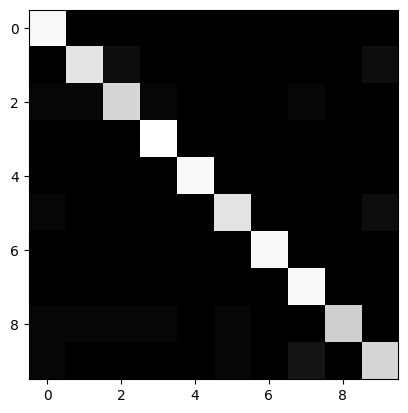

In [57]:
plt.imshow(confusion, cmap="gray")

In [58]:
pd.Series(preds).value_counts()

7    40
0    40
3    39
6    36
4    36
9    35
1    35
5    35
2    34
8    30
dtype: int64

In [59]:
(y_test == preds).mean()

0.9416666666666667

In [60]:
y_test[:10], preds[:10]

(array([7, 8, 7, 6, 6, 6, 2, 2, 5, 1]), [7, 8, 7, 6, 6, 6, 2, 2, 9, 1])

In [61]:
fhat

{0: 1.9785759882104245e-14,
 1: 2.7007888553700606e-14,
 2: 8.908973529114366e-14,
 3: 6.477819328803835e-14,
 4: 4.360659272540591e-15,
 5: 2.5903254249196512e-14,
 6: 1.0837859866022533e-14,
 7: 4.369021341376912e-14,
 8: 4.8558693111141274e-14,
 9: 2.6669234122400006e-14}

In [62]:
pd.Series(y_test).value_counts(), pd.Series(preds).value_counts()

(1    37
 3    37
 7    36
 6    36
 5    36
 0    36
 9    36
 4    36
 8    35
 2    35
 dtype: int64,
 7    40
 0    40
 3    39
 6    36
 4    36
 9    35
 1    35
 5    35
 2    34
 8    30
 dtype: int64)

In [63]:
{i: np.mean(cls["dists"]) for i, cls in classes.items()}

{0: 680.3201745685379,
 1: 1449.3503923900118,
 2: 1274.6835945248959,
 3: 1143.2045411897166,
 4: 1249.3197621878717,
 5: 1374.511259148058,
 6: 866.0337693222355,
 7: 1269.7855151841165,
 8: 1362.5797836550903,
 9: 1371.6139081790122}

In [64]:
pd.DataFrame(runs).to_csv("runs.csv", index=False)

In [65]:
df = pd.read_csv("runs.csv")

In [66]:
df[df.alpha.isna() | (df.k == 100)]

,method,score,ds,size,i,alpha,k
0,rf,0.922222,digits,0.1,0,NaN,NaN
